In [1]:
from typing import List
import numpy as np

from pyquil import Program
from pyquil.gates import MEASURE, I, CNOT, X, H, CZ, RY
from pyquil.quil import address_qubits
from pyquil.quilatom import QubitPlaceholder
from pyquil.api import QVMConnection
from pyquil.noise import pauli_kraus_map, dephasing_kraus_map

In [2]:
qvm = QVMConnection()

In [3]:
def NN_scheme_encode(qubit: QubitPlaceholder, N: int) -> (Program, List[QubitPlaceholder]):
    
    ### qubit: qubit you want to encode (main qubit)
    ### N: number of qubits you want to encode the main qubit in. 
    ### For N=1, there is no encoding
    
    code_register = QubitPlaceholder.register(N)  # the List[QubitPlaceholder] of the qubits you have encoded into
    code_register[0] = qubit
    
    pq = Program()
    
    ### creation of GHZ state: 
    for ii in range(N-1):
        pq += CNOT(code_register[ii],code_register[ii+1])
        
        
    for jj in range(N-1):
        pq += H(code_register[jj])
        pq += CZ(code_register[jj+1],code_register[jj])
        
    
    for kk in range(N-1):
        pq += CNOT(code_register[kk],code_register[-1])

    return pq, code_register


def NN_scheme_decode(code_register: List[QubitPlaceholder]) -> (Program, QubitPlaceholder):
    
    out = QubitPlaceholder()
    n = len(code_register)
    
    pq = Program()
    
    ### This is where the magic happens
    for ii in range(n):
        pq += CNOT(code_register[ii],out)
        
        
    return pq, out


def NN_scheme_test(qubit, prep_program, N_encode, N_decode):
    
    ### qubit: qubit we want to encode (main qubit)
    ### prep_program: arbitrary program to put the main qubit in the state we want to 
    ### transmit
    ### N_encode: number of qubits to encode the main qubit in
    ### N_decode: number of qubits to read out
    ### if N_decode < N_encode, we will always get alpha squared = beta squared = 0.5,
    ### no matter what we originally encoded the qubit in.
    ### Note that this test only gives the absolute squared values of alpha and beta

    pq = Program()
    pq += prep_program
        
    prog, code_register = NN_scheme_encode(qubit,N_encode)

    pq += prog

    progg, out = NN_scheme_decode(code_register[0:N_decode])

    pq += progg

    ro = pq.declare('ro', 'BIT', 1)
    pq += MEASURE(out, ro)

    result = np.sum(qvm.run(address_qubits(pq), trials=1000))/1000.0
    
    alpha_sqrd = 1.0 - result
    beta_sqrd = result
    
    print('alpha squared = {}'.format(alpha_sqrd))
    print('beta squared = {}'.format(beta_sqrd))
    
    return alpha_sqrd, beta_sqrd

In [6]:
test = QubitPlaceholder()
pq = Program()
# pq += X(XX)

pq += RY(2.0*np.pi/3.0,test)

N_encode, N_decode = 4, 4

alpha_sqrd, beta_sqrd = NN_scheme_test(test, pq, N_encode, N_decode)

alpha squared = 0.236
beta squared = 0.764


In [76]:
from matplotlib import pyplot as plt
def simulate_NN(kraus_operators, qubit, prep_program, N) -> int:
    """
    :param kraus_operators: The set of Kraus operators to apply as the noise model on the identity gate
    :param trials: The number of times to simulate the program
    :param error_code: The error code {bit_code, phase_code or shor} to use
    :return: The number of times the code did not correct back to the logical zero state for "trials" attempts
    """
    # Apply the error_code to some qubits and return back a Program pq
    pq = Program()
    pq += prep_program
        
    prog, code_register = NN_scheme_encode(qubit,N)

    pq += prog


    # THIS CODE APPLIES THE NOISE FOR YOU
    kraus_ops = kraus_operators
    noise_data = Program()
    for qq in range(N):
        noise_data.define_noisy_gate("I", [qq], kraus_ops)
    pq = noise_data + pq
    
    for ii in range(N):
        pq += I(code_register[ii])
    
    prog2, out = NN_scheme_decode(code_register)
    
    pq += prog2
    ro = pq.declare('ro', 'BIT', 1)
    pq += MEASURE(out, ro)
    
    print(pq)


    score = np.sum(qvm.run(address_qubits(pq), trials=1000))

    return score

In [21]:
def bit_flip_channel(prob: float):
    noisy_I = np.sqrt(1-prob) * np.asarray([[1, 0], [0, 1]])
    noisy_X = np.sqrt(prob) * np.asarray([[0, 1], [1, 0]])
    return [noisy_I, noisy_X]

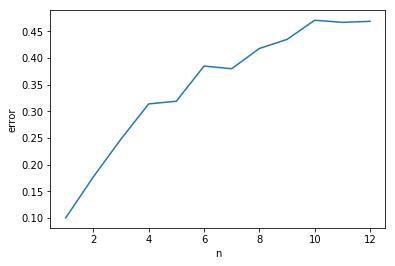

In [75]:
kraus = bit_flip_channel(0.1)

qubit = QubitPlaceholder()

prep_program = Program()

N = np.linspace(1,12,12)
score = np.zeros(len(N))

for ii in range(len(N)):

    score[ii] = simulate_NN(kraus, qubit, prep_program,int(N[ii]))

plt.plot(N,score/1000)

plt.xlabel('n')
plt.ylabel('error')

plt.savefig('nn_error.png', dpi=300)

